## 필요한 라이브러리 설치, 사용할 모델 불러오기

In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from konlpy.tag import Okt
import sys
import requests
from bs4 import BeautifulSoup
okt = Okt()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

model = AutoModelForMaskedLM.from_pretrained("klue/roberta-large")

## 유의어 찾기

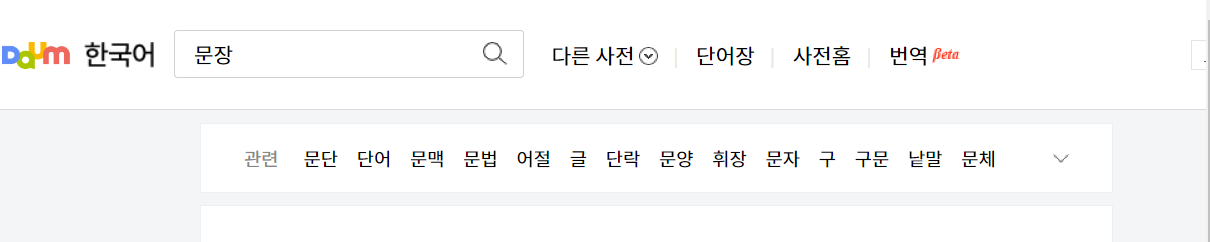

In [5]:
#다음 사전에서 단어 입력하면 위에 뜨는 관련 단어들을 가져오는 함수
def search_daum_dic(query_keyword):
    dic_url = """http://dic.daum.net/search.do?q={0}"""
    r = requests.get(dic_url.format(query_keyword))
    soup = BeautifulSoup(r.text, "html.parser")
    result_means = soup.find_all(attrs={'class':'link_relate'})

    word = []
    i=0
    for elem in result_means:
        text = elem.get_text().strip()
        word.append(text.split())
    return word

In [6]:
#사용자가 바꾸려고 선택한(드래그한) 단어를 [MASK]로 치환해주는 함수
def masking(word_list, new_input, mask):
  i=0
  for i in range(0, len(word_list)):
    if new_input[i]==mask:
      new_input[i] = "[MASK]"


  print(new_input) #확인용
  new_sentence = ' '.join(new_input)
  return new_sentence

In [7]:
#올바른 비교를 위해 모델의 input 문장과 유의어들을 전처리하는 함수
def preprocess(new_sentence, mask):
  synDict = search_daum_dic(mask)
  i=0
  if len(synDict)==0:
    print("교체할 수 있는 단어가 없습니다")
    exit(0)
  for i in range(0, len(synDict)): 
    synDict[i] = str(synDict[i])
    synDict[i] = synDict[i].replace("['","")
    synDict[i] = synDict[i].replace("']","")
  #print(synDict) #참고용
  new_sentence = new_sentence.replace("[MASK] ", "[MASK]")
  return new_sentence, synDict

In [8]:
#확률값을 계산하고 그 값이 큰 단어부터 텐서를 정렬하는 함수
def calculate(new_sentence):
  inputs = tokenizer(new_sentence, return_tensors="pt")
  with torch.no_grad():
    logits = model(**inputs).logits
  mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
  ts = torch.sort(logits[0, mask_token_index], dim=- 1, descending=True)
  return ts

In [9]:
#텐서 안에 32000개의 단어의 인덱스가 들어가있습니다. 그래서 그만큼 비교하는 루프를 작성했습니다.
def max_logit(tensor, synDict):
  word_list = []
  k=0
  size = len(synDict)
  for i in range(0, 32000):
    for j in range(0,size):
      if str(tokenizer.decode(tensor[1][0][i])) == synDict[j]:
        word_list.append(tensor[1][0][i])
        k+=1
        break
    if k==3:
      break
  return word_list

In [10]:
#문장을 입력하고 대체 단어를 추출하는 함수
def recommend():
  origin = str(input("문장을 입력해주세요:"))
  word_list = okt.pos(origin)
  print(word_list)
  print("바꿀 단어를 선택해주세요.")
  k=0
  new_input = []
  for k in range(0,len(word_list)):
    new_input.append(word_list[k][0])
  hubo = word_list
  i=0
  j=1
  for i in range(len(word_list)):
    if word_list[i][1]=='Adverb':
      print(j, '. ', word_list[i][0])
      hubo[j] = word_list[i][0]
      j+=1
  #Verb의 경우 활용형에 대한 처리가 특히 필요하므로 추후 개발 예정.
  # elif word_list[i][1]=='Verb':
  #   print(j, '. ', word_list[i][0])
  #   hubo[j] = word_list[i][0]
  #   j+=1
    elif word_list[i][1]=='Noun':
      print(j, '. ', word_list[i][0])
      hubo[j] = word_list[i][0]
      j+=1
    elif word_list[i][1]=='Adjective':
      print(j, '.', word_list[i][0])
      hubo[j] = word_list[i][0]
      j+=1
    i+=1
  n = int(input("바꿀 단어의 번호(숫자만 입력하세요) : "))
  mask = hubo[n]
  #mask로 치환
  new_sentence = masking(word_list, new_input, mask)
  #비교를 위한 전처리
  new_sentence, synDict = preprocess(new_sentence, mask)
  ts = calculate(new_sentence)
  a = []
  if (synDict):
    a = max_logit(ts, synDict)
  i=0
  for i in range(0,len(a)):#최대 세 개
    print(tokenizer.decode(int(a[i])))

In [11]:
recommend()

문장을 입력해주세요:여기에 문장을 적어보면 바꿀 수 있는 단어를 알려줄 거야
[('여기', 'Noun'), ('에', 'Josa'), ('문장', 'Noun'), ('을', 'Josa'), ('적어', 'Verb'), ('보면', 'Verb'), ('바꿀', 'Verb'), ('수', 'Noun'), ('있는', 'Adjective'), ('단어', 'Noun'), ('를', 'Josa'), ('알려줄', 'Verb'), ('거야', 'Eomi')]
바꿀 단어를 선택해주세요.
1 .  여기
2 .  문장
3 .  수
4 . 있는
5 .  단어
바꿀 단어의 번호(숫자만 입력하세요) : 2
['여기', '에', '[MASK]', '을', '적어', '보면', '바꿀', '수', '있는', '단어', '를', '알려줄', '거야']
글
문법
낱말


##앞으로 해야 할 것:
- 대체 가능어 사전을 어떻게 구축하고 끌어올지 결정  
- 바꿀 수 있는 단어들의 활용형을 조건문을 통해 구현 
  - 사용자가 '사용하려면'을 드래그한다면 '사용하다'의 유의어를 찾고 다시 활용형으로 변경
  - 바뀐 대체어에 따라 조사의 형태를 변경(예: 은/는)  
- 더 정확한 대체어 추천을 위해 다른 형태소 분석기 결정
- 코드 수정해서 한 문장에 같은 단어가 있는 경우에도 드래그한 단어만 바꿀 수 있도록 처리